In [2]:
# Estimate the fraction of people you follow on Twitter that are female. 
# In 2020, 39% of Twitter users are female. 
# https://www.statista.com/statistics/828092/distribution-of-users-on-twitter-worldwide-gender/
# To put this in context, estimate the same for people you follow.
# Uses tweepy and gender_guesser packages.
#
# To use the Twitter API, you must create a Developer application:
# https://apps.twitter.com/
# Select the Create New App button and fill out the application information.
# You will ultimately need the following pieces of information:
#
#    API key
#    API secret key
#    Access token
#    Access token secret
# 
# These should be stored in a CSV file that looks like:
# API key,XXXXXXXXXXXXXXXXXXXXXXXXX
# API secret key,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
# Access token,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
# Access token secret,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [3]:
# set up environment
import numpy as np
import tweepy
import matplotlib.pyplot as plt
import gender_guesser.detector as gender
import re
import scipy
import scipy.ndimage as ndimage
import scipy.stats as stats
import scipy.interpolate as interpolate
import matplotlib.colors as mcolors
import csv

In [4]:
# set up tweepy authentication

# edit authfile to point to CSV file with your Twitter application information
authfile = 'C:/Users/bransonk/.twitter/KristinsGenderRatioAnalysis.csv'
# edit rootusername to be your screen name on Twitter
rootusername = 'kristinmbranson'

authinfo = {}
with open(authfile) as csvfile:
    csvreader = csv.reader(csvfile,delimiter=',')
    for row in csvreader:
        authinfo[row[0]] = row[1]

#print(authinfo)
auth = tweepy.OAuthHandler(authinfo['API key'], authinfo['API secret key'])
auth.set_access_token(authinfo['Access token'],authinfo['Access token secret'])
api = tweepy.API(auth,wait_on_rate_limit=True,
                 wait_on_rate_limit_notify=True)


In [5]:
# gets the names and ids of followers for an input id/screen name
def get_following_names(id,api,batchsize = 100,ids1=None):
    if ids1 is None:
        ids1 = api.friends_ids(id)
    namescurr = []
    for i0 in range(0,len(ids1),batchsize):
        i1 = min(len(ids1),i0+batchsize)
        user_objs = api.lookup_users(user_ids=ids1[i0:i1])
        namescurr = namescurr + list(map(lambda x: x.name,user_objs))
    namescurr.reverse()
    ids1.reverse()
    return namescurr,ids1

In [22]:
# classifies gender of names, and computes some statistics
def compute_gender_info(names,ids=None,verbose=False,sigma = 5):
    # "names" that mean this is likely not a name
    badnames = ['Lab','lab','The','the','Stanford','Mag','Club','Adventure','Rock','Conference','Global','HHMI','Amazon','Google','Facebook','ICLR']

    # gender indicators
    kwfemale = ['female','mostly_female']
    kwmale = ['male','mostly_male']
    
    # classify gender
    d = gender.Detector()
    gs = []
    firstnames = []
    for name in names:
        nameparts = re.split('\s+',name)
        if not list(filter(lambda x: x in badnames,nameparts)) == []:
            if verbose:
                print('%s contains name we are ignoring'%name)
            gs.append('unknown')
        else:
            gs.append(d.get_gender(nameparts[0].capitalize()))
        if verbose: print('%s -> %s -> %s'%(name,nameparts[0],gs[-1]))
    
    # get info for names that we could classify
    kwknown = kwfemale + kwmale
    isknown = list(map(lambda x: x in kwknown,gs))
    knowngs = list(filter(lambda x: x in kwknown,gs))
    isfemale = list(map(lambda x: x in kwfemale,knowngs))
    ismale = list(map(lambda x: x in kwmale,knowngs))
    if ids is not None:
        idsknown = []
    else:
        idsknown = None
    namesknown = []
    gsknown = []
    for i in range(len(isknown)):
        if isknown[i]:
            if ids is not None:
                idsknown.append(ids[i])
            namesknown.append(names[i])
            gsknown.append(gs[i])
            
    # fraction female over time
    num = np.cumsum(np.array(isfemale))
    den = np.arange(len(isfemale))+1
    fracfemale = num/den
    fracfemale_filtered = ndimage.gaussian_filter(fracfemale,sigma,mode='nearest')
    
    res = {'gs': gs, 'isknown': isknown,'isfemale': isfemale,'ismale': ismale,
           'knowngs': knowngs,'namesknown': namesknown,
           'fracfemale': fracfemale,'fracfemale_filtered': fracfemale_filtered,
           'names': names, 'idsknown': idsknown,'gsknown': gsknown}
    return res
    

In [7]:
# chooses random samples from people you follow with at least minnfollowing people they are following
def choose_samples_helper(idx,myinfo,api,nsample=20,minnfollowing=100,verbose=False):
    isselected = np.zeros(idx.shape,dtype=bool)
    idxsample = []
    ids1 = []

    while True:
        if np.all(isselected) or len(idxsample) >= nsample:
            break
        idxcurr, = np.nonzero(isselected==False)
        i = np.random.randint(0,len(idxcurr)) # indexes into idxcurr
        i = idxcurr[i] # indexes into isselected
        isselected[i] = True
        i = idx[i] # indexes into myinfo
        id = myinfo['idsknown'][i]
        idscurr = api.friends_ids(id)
        if verbose:
            print('%d: selected %d (%s), nfollowing = %d'%(len(idxsample),id,
                                                           myinfo['namesknown'][i],
                                                           len(idscurr)))
        if len(idscurr) >= minnfollowing:
            print('Adding')
            idxsample.append(i)
            ids1.append(idscurr)
    return (idxsample,ids1)

def choose_samples(myinfo,nsample=20,minnfollowing=100,verbose=False):
    
    isfemale = np.array(myinfo['isfemale'])
    idxfemale, = np.nonzero(isfemale)
    idxmale, = np.nonzero(isfemale==False)

    idxsample_female,ids1_female = \
        choose_samples_helper(idxfemale,myinfo,api,nsample=nsample,minnfollowing=minnfollowing,verbose=verbose)
    idxsample_male,ids1_male = \
        choose_samples_helper(idxmale,myinfo,api,nsample=nsample,minnfollowing=minnfollowing,verbose=verbose)

    nsample_female = len(idxsample_female)
    nsample_male = len(idxsample_male)
    ids1 = ids1_female + ids1_male
    idxsample = idxsample_female + idxsample_male
    
    return idxsample,ids1,nsample_female,nsample_male
    

In [62]:
def get_tweets(screen_name,maxntweets=np.Inf):
    statuses = []
    ntweets = 0
    for status in tweepy.Cursor(api.user_timeline,screen_name,include_rts=True).items():
        statuses.append(status)
        ntweets += 1
        if ntweets >= maxntweets:
            break
            
    statuses.reverse()
    return statuses

def get_retweet_names(statuses,verbose=False):
    
    retweet_names = []
    retweet_types = []
    isretweet = np.zeros(len(statuses))==0
    
    for i in range(len(statuses)):
        status = statuses[i]

        if hasattr(status,'is_quote_status') and status.is_quote_status and \
        hasattr(status,'quoted_status'):
            name = status.quoted_status.author.name
            retweet_names.append(name)
            retweet_types.append('quote')
            if verbose:
                print('%d: quote %s'%(i,name))
        elif hasattr(status,'retweeted_status'):
            name = status.retweeted_status.author.name
            retweet_names.append(name)
            retweet_types.append('retweet')
            if verbose:
                print('%d: retweet %s'%(i,name))
        elif hasattr(status,'in_reply_to_screen_name') and \
        status.in_reply_to_screen_name is not None:
            if status.in_reply_to_screen_name.lower() == rootusername.lower():
                if verbose:
                    print('%d: reply to own tweet'%i)
            else:
                in_reply_to_name = None
                for u in status.entities['user_mentions']:
                    if(u['screen_name'].lower() == status.in_reply_to_screen_name.lower()):
                        in_reply_to_name = u['name']
                        break
                if in_reply_to_name == None:
                    isretweet[i] = False
                    if verbose:
                        print('%d: reply to ??'%i)
                else:
                    retweet_names.append(in_reply_to_name)
                    retweet_types.append('reply')
                    if verbose:
                        print('%d: reply %s'%(i,in_reply_to_name))
        else:
            isretweet[i] = False
            if verbose:
                print('%d: ??'%i)
                print(status.text)
                
    return (retweet_names,retweet_types,isretweet)


In [68]:
# load data from file

import pickle
filename = 'C:/Code/TwitterGenderRatio/test20200510.pickle'
fid = open(filename,'rb')
res = pickle.load(fid)
fid.close()

ids = res['ids']
names = res['names']
idxsample = res['idxsample']
names1 = res['names1']
ids1 = res['ids1']
nsample_female = len(idxsample)//2

In [9]:
# get names & ids of people I follow
names,ids = get_following_names(rootusername,api)
print('Number following: %d'%len(names))

Number following: 488


Fraction of people I follow who are female: 0.485030


Text(0, 0.5, 'Fraction female')

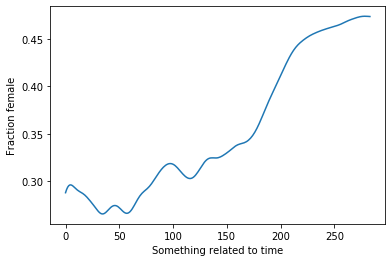

In [10]:
# classify gender based on first name
sigma = 5
myinfo = compute_gender_info(names,ids,verbose=False,sigma=sigma)
print('Fraction of people I follow who are female: %f'%myinfo['fracfemale'][-1])

# plot fraction female
plt.plot(myinfo['fracfemale_filtered'][5*sigma:-5*sigma])
plt.xlabel('Something related to time')
plt.ylabel('Fraction female')


iNaturalist -> iNaturalist -> unknown
FGVC Workshop -> FGVC -> unknown
KDnuggets -> KDnuggets -> unknown
Jeff Chen -> Jeff -> male
Vincent Conitzer -> Vincent -> male
Facebook AI contains name we are ignoring
Facebook AI -> Facebook -> unknown
Karla Kaun -> Karla -> female
Distill -> Distill -> unknown
Benjamin (virus hunter) Himes -> Benjamin -> male
Benjamin (virus hunter) Himes -> Benjamin -> male
ICLR 2020 contains name we are ignoring
ICLR 2020 -> ICLR -> unknown
Adam J Calhoun -> Adam -> male
Nature -> Nature -> unknown
Serge Belongie -> Serge -> male
Crystal Watson, DrPH -> Crystal -> female
Judith MitraniReiser -> Judith -> female
Bored Yann LeCun -> Bored -> unknown
Adam J Calhoun -> Adam -> male
Pavel Tomancak -> Pavel -> male
Benjamin de Bivort -> Benjamin -> male
Benjamin de Bivort -> Benjamin -> male
Karla Kaun -> Karla -> female
Stephan Saalfeld -> Stephan -> male
Anne Carpenter -> Anne -> female
The Washington Post contains name we are ignoring
The Washington Post -> The

Text(0.5, 1.0, 'People I retweet')

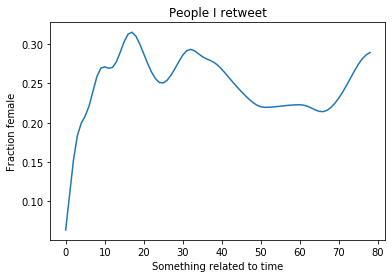

In [35]:
# look at gender ratio for people I retweet

maxntweets = 400
mystatuses = get_tweets(rootusername,maxntweets=maxntweets)
myretweetnames,myretweettypes,myisretweet = get_retweet_names(mystatuses,verbose=False)
myretweetinfo = compute_gender_info(myretweetnames,verbose=False,sigma=2)
print('Fraction of people I retweeted who are female: %f'%myretweetinfo['fracfemale'][-1])

# plot fraction female
plt.plot(myretweetinfo['fracfemale_filtered'])
plt.xlabel('Something related to time')
plt.ylabel('Fraction female')
plt.title('People I retweet')


In [8]:
# choose some random following
nsample = 50
minnfollowing = 100
idxsample,ids1,nsample_female,nsample_male = \
    choose_samples(myinfo,nsample=nsample,minnfollowing=minnfollowing,verbose=True)

assert nsample==nsample_female and nsample==nsample_male,'Did not find enough samples with minnfollowing = %d'%minnfollowing

0: selected 207665930 (Serena Yeung), nfollowing = 120
Adding
1: selected 1359059238 (Dima Damen), nfollowing = 341
Adding
2: selected 19563103 (Gwen Pearson), nfollowing = 841
Adding
3: selected 1890694861 (Rose Yu), nfollowing = 294
Adding
4: selected 731538535795163136 (Sara Hooker), nfollowing = 1682
Adding
5: selected 737478121079906304 (Judith MitraniReiser), nfollowing = 676
Adding
6: selected 178588367 (Karla Kaun), nfollowing = 839
Adding
7: selected 345129453 (Nan Rosemary Ke), nfollowing = 338
Adding
8: selected 35269421 (Ellie Heckscher), nfollowing = 516
Adding
9: selected 2369329526 (Ulrike Boehm 🔬👩🏻‍💻), nfollowing = 286
Adding
10: selected 1135303672219545600 (Marcella Noorman), nfollowing = 45
10: selected 2577596593 (Chelsea Finn), nfollowing = 244
Adding
11: selected 217852227 (Elizabeth C. Gorski), nfollowing = 630
Adding


Rate limit reached. Sleeping for: 871


12: selected 1237734334385344512 (Mai Morimoto), nfollowing = 173
Adding
13: selected 3318332379 (Ilana Witten), nfollowing = 602
Adding
14: selected 1431348835 (Anne Carpenter), nfollowing = 1117
Adding
15: selected 1237147828704575488 (Sara Beery), nfollowing = 759
Adding
16: selected 36819554 (Megan Carey), nfollowing = 933
Adding
17: selected 22385548 (Jane Wang), nfollowing = 339
Adding
18: selected 908902292 (Marta Costa), nfollowing = 207
Adding
19: selected 875432666555965444 (Krystyna Keleman), nfollowing = 213
Adding
20: selected 3072541911 (Stephanie Albin), nfollowing = 498
Adding
21: selected 788467623629500416 (Doris Tsao), nfollowing = 252
Adding
22: selected 2389878942 (Emily Behrman), nfollowing = 340
Adding
23: selected 950751996084150272 (Larissa Heinrich), nfollowing = 86
23: selected 843706252517502977 (Christine Käser-Chen), nfollowing = 184
Adding
24: selected 45675087 (Devi Parikh), nfollowing = 125
Adding
25: selected 2704715387 (Jen Heemstra), nfollowing = 500

Rate limit reached. Sleeping for: 897


27: selected 305092591 (Emma Brunskill), nfollowing = 52
27: selected 43406294 (renan ozturk), nfollowing = 176
Adding
28: selected 19087450 (Edith Zimmerman), nfollowing = 989
Adding
29: selected 215113195 (Naomi Saphra), nfollowing = 1011
Adding
30: selected 979697205664800768 (Elizabeth Hillman), nfollowing = 815
Adding
31: selected 959028649528840192 (Virginie Uhlmann), nfollowing = 159
Adding
32: selected 870108900128903169 (Claire Deo), nfollowing = 285
Adding
33: selected 2405083879 (eugenia chiappe), nfollowing = 422
Adding
34: selected 25320089 (Grace Vesom), nfollowing = 387
Adding
35: selected 16520284 (Alice Oh), nfollowing = 436
Adding
36: selected 748267272939020293 (Laura Leal-Taixe), nfollowing = 60
36: selected 2172505322 (Kathryn Brown), nfollowing = 27
36: selected 535136727 (Dawn Song), nfollowing = 704
Adding
37: selected 842164502422417409 (Adrienne Fairhall), nfollowing = 276
Adding
38: selected 16017475 (Nate Silver), nfollowing = 1288
Adding


Rate limit reached. Sleeping for: 896


39: selected 159315527 (Jewel Burks Solomon), nfollowing = 3858
Adding
40: selected 822090549490499585 (Nadine Gogolla), nfollowing = 749
Adding
41: selected 28912478 (Leslie Vosshall PhD), nfollowing = 497
Adding
42: selected 925800751628279808 (Nan Jiang), nfollowing = 46
42: selected 1235552122957115394 (Carolina Wählby), nfollowing = 0
42: selected 869862586610851840 (Jeannette Bohg), nfollowing = 254
Adding
43: selected 700532262165676033 (Sarah Certel), nfollowing = 247
Adding
44: selected 21828411 (Erin LeDell), nfollowing = 4995
Adding
45: selected 2869101210 (Jenn Wortman Vaughan), nfollowing = 354
Adding
46: selected 1143074659291680768 (Ann Kennedy), nfollowing = 169
Adding
47: selected 2460047754 (Janelle Shane), nfollowing = 885
Adding
48: selected 543919023 (Martha White), nfollowing = 52
48: selected 276643081 (Cori Bargmann), nfollowing = 732
Adding
49: selected 1035389878605885440 (Athena Akrami), nfollowing = 356
Adding


Rate limit reached. Sleeping for: 896


0: selected 14986849 (Alex Smola), nfollowing = 67
0: selected 828056721750896640 (mark cembrowski), nfollowing = 404
Adding
1: selected 29843511 (Nando de Freitas), nfollowing = 358
Adding
2: selected 261789755 (jeremy freeman), nfollowing = 1572
Adding
3: selected 791306523062497280 (Wyatt Korff), nfollowing = 13
3: selected 234270825 (Ken Jennings), nfollowing = 551
Adding
4: selected 190138220 (Jonathan Pillow), nfollowing = 1153
Adding
5: selected 27648853 (Peter), nfollowing = 1018
Adding
6: selected 433741920 (Marius Pachitariu), nfollowing = 1008
Adding
7: selected 769978990706720768 (Raphael Turcotte), nfollowing = 161
Adding
8: selected 780291008 (karel svoboda), nfollowing = 226
Adding
9: selected 1033383109440356352 (Oisin Mac Aodha), nfollowing = 326
Adding
10: selected 128781736 (Sasha DiGiulian), nfollowing = 620
Adding
11: selected 1014691 (David Cho), nfollowing = 593
Adding
12: selected 1150552125065355264 (Jan Funke), nfollowing = 55
12: selected 18098674 (Brendan Qu

Rate limit reached. Sleeping for: 896


12: selected 1193222240202035200 (Andrew Saxe), nfollowing = 186
Adding
13: selected 197684961 (Misha Denil), nfollowing = 952
Adding
14: selected 48008938 (Yann LeCun), nfollowing = 282
Adding
15: selected 911297187664949248 (Jeff Dean (@🏡)), nfollowing = 3100
Adding
16: selected 172101003 (Greg Jefferis), nfollowing = 783
Adding
17: selected 1242216846033473537 (Manuel Mohr), nfollowing = 59
17: selected 56786888 (Martin Jones), nfollowing = 3935
Adding
18: selected 636023721 (Adam J Calhoun), nfollowing = 1026
Adding
19: selected 919035620 (Matthieu Louis), nfollowing = 35
19: selected 53514472 (Andrew Fitzgibbon), nfollowing = 461
Adding
20: selected 19301221 (Andrew S. Champion), nfollowing = 248
Adding
21: selected 50393960 (Bill Gates), nfollowing = 218
Adding
22: selected 149895490 (Gonzalo de Polavieja), nfollowing = 1046
Adding
23: selected 3333052551 (Hugo Larochelle), nfollowing = 527
Adding
24: selected 1026931440280391687 (Kaspar Podgorski), nfollowing = 203
Adding


Rate limit reached. Sleeping for: 896


25: selected 3111733301 (Daniel Gonzales), nfollowing = 926
Adding
26: selected 1400517288 (Sandeep Robert Datta), nfollowing = 802
Adding
27: selected 938416059962609665 (Mike Economo), nfollowing = 578
Adding
28: selected 223734352 (Matt Gritzmacher), nfollowing = 531
Adding
29: selected 16055364 (Il Memming Park), nfollowing = 1612
Adding
30: selected 3192303453 (Andreas Kay), nfollowing = 10
30: selected 51582812 (Stephen Holtz), nfollowing = 827
Adding
31: selected 813286 (Barack Obama), nfollowing = 5000
Adding
32: selected 14348594 (John Hodgman), nfollowing = 3860
Adding
33: selected 2848165007 (John Bogovic), nfollowing = 463
Adding
34: selected 122080635 (Sebastian Seung), nfollowing = 292
Adding
35: selected 15035863 (Noah Snavely), nfollowing = 378
Adding
36: selected 1210596212140892160 (John Langford), nfollowing = 21
36: selected 19767193 (Ed Yong), nfollowing = 1674
Adding


Rate limit reached. Sleeping for: 897


37: selected 314158631 (Erich Jarvis), nfollowing = 371
Adding
38: selected 14230012 (Rex Parker⚾️🐘🐘🐘⚾️), nfollowing = 359
Adding
39: selected 1173981576046227457 (David E. Clapham), nfollowing = 6
39: selected 930090512 (Stephan Saalfeld), nfollowing = 154
Adding
40: selected 31936449 (Lior Pachter), nfollowing = 1287
Adding
41: selected 33362653 (Trace Henry), nfollowing = 2653
Adding
42: selected 14162415 (Ryan North), nfollowing = 897
Adding
43: selected 221304470 (David Schoppik), nfollowing = 1015
Adding
44: selected 430783446 (Michael Chabon), nfollowing = 38
44: selected 809072402282016768 (Daniel Jiwoong Im), nfollowing = 509
Adding
45: selected 2847954257 (Frank), nfollowing = 145
Adding
46: selected 29905013 (Peter Gordon), nfollowing = 28
46: selected 4558314927 (Sasha Rush), nfollowing = 325
Adding
47: selected 946827254901936130 (Davis Bennett), nfollowing = 77
47: selected 22445339 (Fred "Replace Trump Now" Wolf), nfollowing = 408
Adding
48: selected 2835683058 (Silvio S

Rate limit reached. Sleeping for: 896


48: selected 57663013 (Jesse Marshall), nfollowing = 191
Adding
49: selected 259568572 (Benjamin de Bivort), nfollowing = 1031
Adding


In [47]:
sampleids = list(map(lambda x: myinfo['idsknown'][x],idxsample))
samplenames = list(map(lambda x: myinfo['namesknown'][x],idxsample))
print('Female samples:')
print(samplenames[:nsample_female])
print('Male samples:')
print(samplenames[nsample_female:])

Female samples:
['Jeannette Bohg', 'Laura Leal-Taixe', 'Naomi Saphra', 'Bill Gates', 'Nan Rosemary Ke', 'Judith MitraniReiser', 'Karla Kaun', 'Martha White', 'Davis Bennett', 'Allan Wong', 'John Hodgman', 'Elizabeth C. Gorski', 'Ellie Heckscher', 'Athena Akrami', 'Anne Carpenter', 'Barack Obama', 'Alex Wild', 'Jane Wang', 'Sara Beery', 'Adam L. Taylor', 'Chris Potter', 'Sasha Rush', 'Eric Schreiter', 'Alex Smola', 'Edith Zimmerman', 'Jen Heemstra', 'Elena Rivas', 'Tommy Caldwell', 'David Cho', 'Ted Pedersen', 'Elijah Cole', 'Martin Jones', 'Mike Economo', 'Andrew S. Champion', 'Grace Vesom', 'Rachel Thomas', 'Shakir Mohamed', 'Matt Gritzmacher', 'Erich Jarvis', 'Jewel Burks Solomon', 'Serena Yeung', 'Kay M Tye', 'Silvio Savarese', 'Sarah Certel', 'Matthieu Louis', 'Tessa Montague', 'Krystyna Keleman', 'Sara Hooker', 'Sebastian Seung', 'Noah Snavely']
Male samples:
['Stephanie Albin', 'Nando de Freitas', 'Jim Keeley', 'Doris Tsao', 'Surya Ganguli', 'karel svoboda', 'Misha Ahrens', 'Mari

In [10]:
# get names of their following
batchsize = 100
names1 = []
for samplei in range(len(names1),len(idxsample)):
    sample = idxsample[samplei]
    id = myinfo['idsknown'][sample]
    print('samplei = %d, sample = %d, id = %d'%(samplei,sample,id))
    namescurr,idscurr = get_following_names(id,api,ids1=ids1[samplei])
    names1.append(namescurr)
    ids1.append(idscurr)


samplei = 0, sample = 152, id = 207665930
samplei = 1, sample = 200, id = 1359059238
samplei = 2, sample = 194, id = 19563103
samplei = 3, sample = 167, id = 1890694861
samplei = 4, sample = 182, id = 731538535795163136
samplei = 5, sample = 15, id = 737478121079906304
samplei = 6, sample = 19, id = 178588367
samplei = 7, sample = 183, id = 345129453
samplei = 8, sample = 174, id = 35269421
samplei = 9, sample = 118, id = 2369329526
samplei = 10, sample = 92, id = 2577596593
samplei = 11, sample = 31, id = 217852227
samplei = 12, sample = 173, id = 1237734334385344512
samplei = 13, sample = 87, id = 3318332379
samplei = 14, sample = 4, id = 1431348835
samplei = 15, sample = 156, id = 1237147828704575488
samplei = 16, sample = 192, id = 36819554
samplei = 17, sample = 27, id = 22385548
samplei = 18, sample = 155, id = 908902292
samplei = 19, sample = 73, id = 875432666555965444
samplei = 20, sample = 124, id = 3072541911
samplei = 21, sample = 178, id = 788467623629500416
samplei = 22, 

In [49]:
# compute gender ratio info
otherinfo = []
for i in range(len(names1)):
    #print('i = %d: %s -> first name = %s'%(i,sample_user_objs[i].name,names1[i][0]))
    otherinfo.append(compute_gender_info(names1[i],ids=ids1[i],verbose=False,sigma=sigma))
    

My percentile among women I follow: 86.000000
My percentile among men I follow: 92.000000
My percentile among people I follow: 89.000000


MannwhitneyuResult(statistic=1463.0, pvalue=0.07146909115821613)

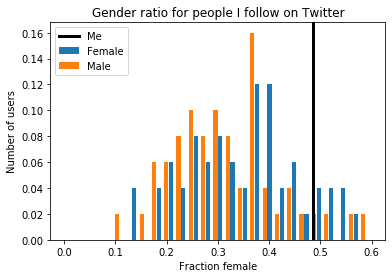

In [56]:
# plot a histogram of frac female following for samples and for me
nbins = 25
# choose some colors
colors = list(mcolors.TABLEAU_COLORS)
colorf = colors[0]
colorm = colors[1]

fracfemale_f = np.zeros(nsample_female)
fracfemale_m = np.zeros(nsample_female)
for i in range(nsample_female):
    if len(otherinfo[i]['fracfemale']) == 0:
        fracfemale_f[i] = np.nan
        print('Bad sample %d'%i)
    else:
        fracfemale_f[i] = otherinfo[i]['fracfemale'][-1]
    if len(otherinfo[i+nsample_female]['fracfemale']) == 0:
        fracfemale_m[i] = np.nan
        print('Bad sample %d'%i+nsample_female)
    else:
        fracfemale_m[i] = otherinfo[i+nsample_female]['fracfemale'][-1]

edges = np.linspace(0,max(np.amax(fracfemale_f),np.amax(fracfemale_m)),nbins+1)
width = edges[1]-edges[0]

myprctile_f = np.count_nonzero(fracfemale_f<=myinfo['fracfemale'][-1])/nsample_female
myprctile_m = np.count_nonzero(fracfemale_m<=myinfo['fracfemale'][-1])/nsample_female
print('My percentile among women I follow: %f'%(myprctile_f*100.))
print('My percentile among men I follow: %f'%(myprctile_m*100.))
print('My percentile among people I follow: %f'%((myprctile_f+myprctile_m)*50.))

counts_f,edges = np.histogram(fracfemale_f,bins=25,range=(0,.6))
counts_m,edges = np.histogram(fracfemale_m,bins=25,range=(0,.6))
ctrs = (edges[1:]+edges[:-1])/2.
normcounts_f = counts_f / np.sum(counts_f)
normcounts_m = counts_m / np.sum(counts_m)
plt.bar(ctrs+width/5.,normcounts_f,width=width*.35,color=colorf,label='Female')
plt.bar(ctrs-width/5.,normcounts_m,width=width*.35,color=colorm,label='Male')
ylim = plt.gca().get_ylim()
plt.plot([myinfo['fracfemale'][-1]]*2,ylim,'k-',lw=3,label='Me')
plt.gca().set_ylim(ylim)
plt.legend()
plt.xlabel('Fraction female')
plt.ylabel('Number of users')
plt.title('Gender ratio for people I follow on Twitter')

stats.mannwhitneyu(fracfemale_f,fracfemale_m,alternative='greater')


In [57]:
# get info about following
anonymize = False
samplenames = list(map(lambda x: myinfo['namesknown'][x],idxsample))
samplegenders = list(map(lambda x: myinfo['gsknown'][x],idxsample))

for i in range(len(samplenames)):
    if anonymize:
        if len(otherinfo[i]['fracfemale']) == 0:
            print('anonymous %s: not following anyone'%(samplegenders[i]))
        else:
            print('anonymous %s: %f'%(samplegenders[i],otherinfo[i]['fracfemale'][-1]))
    else:
        if len(otherinfo[i]['fracfemale']) == 0:
            print('%s (%s): not following anyone'%(samplenames[i],samplegenders[i]))
        else:
            print('%s (%s): %f'%(samplenames[i],samplegenders[i],otherinfo[i]['fracfemale'][-1]))

Jeannette Bohg (female): 0.125000
Laura Leal-Taixe (female): 0.225000
Naomi Saphra (female): 0.511530
Bill Gates (male): 0.215789
Nan Rosemary Ke (mostly_female): 0.378406
Judith MitraniReiser (female): 0.501348
Karla Kaun (female): 0.416149
Martha White (female): 0.138889
Davis Bennett (male): 0.441558
Allan Wong (male): 0.353933
John Hodgman (male): 0.207547
Elizabeth C. Gorski (female): 0.392573
Ellie Heckscher (female): 0.371681
Athena Akrami (female): 0.390187
Anne Carpenter (female): 0.384189
Barack Obama (male): 0.428571
Alex Wild (male): 0.403200
Jane Wang (female): 0.187739
Sara Beery (female): 0.315789
Adam L. Taylor (male): 0.244275
Chris Potter (mostly_male): 0.436782
Sasha Rush (mostly_male): 0.314286
Eric Schreiter (male): 0.375000
Alex Smola (male): 0.301887
Edith Zimmerman (female): 0.246377
Jen Heemstra (female): 0.529982
Elena Rivas (female): 0.373134
Tommy Caldwell (male): 0.211765
David Cho (male): 0.466387
Ted Pedersen (male): 0.286614
Elijah Cole (male): 0.367188


[0.5 1.  0.5]


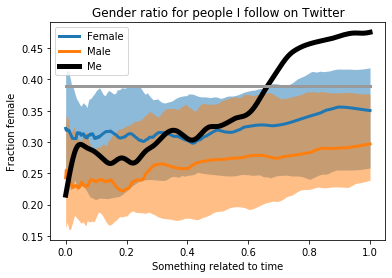

In [58]:
# plot stats of samples and me
maxl = 1000
dointerp = True # whether to plot absolute following number or fraction of following
doplotprctiles = True
allusers_fracfemale = 0.39 # https://www.statista.com/statistics/828092/distribution-of-users-on-twitter-worldwide-gender/

Y = np.zeros((len(otherinfo),maxl))
Y[:] = np.nan
counts = np.zeros((1,maxl))
xinterp = np.linspace(0, 1, maxl)
for i in range(0,len(otherinfo)):
    y = otherinfo[i]['fracfemale_filtered'][3*sigma:-3*sigma]
    if dointerp:
        x = np.linspace(0,1,y.shape[0])
        f = interpolate.interp1d(x,y,axis=0)
        yinterp = f(xinterp)
        Y[i,:] = yinterp
    else:
        l = min(len(y),maxl)
        Y[i,:l] = y[:l]
        
idxfemale = np.arange(0,nsample_female)
idxmale = np.arange(nsample_female,2*nsample_female)

prctiles_compute = np.array([25,50,75])
middlei, = np.where(prctiles_compute==50)
middlei = middlei[0]
prctiles_female = np.percentile(Y[idxfemale,:],prctiles_compute,axis=0)
prctiles_male = np.percentile(Y[idxmale,:],prctiles_compute,axis=0)

mu_female = np.nanmean(Y[idxfemale,:],axis=0)
mu_male = np.nanmean(Y[idxmale,:],axis=0)
sig_female = np.nanstd(Y[idxfemale,:],axis=0)
sig_male = np.nanstd(Y[idxmale,:],axis=0)
counts_female = np.sum(np.isnan(Y[idxfemale,:])==False,axis=0)
counts_male = np.sum(np.isnan(Y[idxmale,:])==False,axis=0)
stderr_female = sig_female / np.sqrt(counts_female)
stderr_male = sig_male / np.sqrt(counts_male)
if dointerp:
    x = xinterp
else:
    x = np.arange(maxl)

if doplotprctiles:
    alpha = (1.-np.abs(50.-np.array(prctiles_compute))/50.)
    print(alpha)
    for i in range(prctiles_compute.shape[0]//2):
        plt.fill_between(x, prctiles_female[i,:], prctiles_female[-i-1,:],alpha=alpha[i],lw=0,color=colorf)
        plt.fill_between(x, prctiles_male[i,:], prctiles_male[-i-1,:],alpha=alpha[i],lw=0,color=colorm)
    hf, = plt.plot(x,prctiles_female[middlei,:],'-',linewidth=3,color=colorf,label='Female')
    hm, = plt.plot(x,prctiles_male[middlei,:],'-',linewidth=3,color=colorm,label='Male')
else:

    # plot mean and standard error
    plt.plot(x,mu_female-sig_female,'-',color=colorf)
    plt.plot(x,mu_female+sig_female,'-',color=colorf)
    hf, = plt.plot(x,mu_female,'-',color=colorf,linewidth=3,label='Female')
    plt.plot(x,mu_male-sig_male,'-',color=colorm)
    plt.plot(x,mu_male+sig_male,'-',color=colorm)
    hm, = plt.plot(x,mu_male,'-',color=colorm,linewidth=3,label='Male')

y = myinfo['fracfemale_filtered'][3*sigma:-3*sigma]
if dointerp:
    x = np.linspace(0,1,y.shape[0])
    f = interpolate.interp1d(x,y,axis=0)
    yinterp = f(xinterp)
    hme, = plt.plot(xinterp,yinterp,'k-',linewidth=5,label='Me')
    plt.plot([0.,1.],[allusers_fracfemale]*2,'-',color=[.6,.6,.6],lw=3)
else:
    hme, = plt.plot(y,'k-',linewidth=5,label='Me')
    plt.plot([0.,len(y)],[allusers_fracfemale]*2,'-',color=[.6,.6,.6],lw=3)
plt.ylabel('Fraction female')
plt.xlabel('Something related to time')
plt.title('Gender ratio for people I follow on Twitter')
plt.legend()

In [63]:
statusescurr = get_tweets(id,maxntweets=maxntweets)
namescurr,retweettypescurr,isretweetcurr = get_retweet_names(statusescurr,verbose=True)

In [66]:
namescurr,retweettypescurr,isretweetcurr = get_retweet_names(statusescurr,verbose=True)

0: ??
Making the cost of a requested experiment very palpable to a reviewer
- after having explained that it was unnecess… https://t.co/4eJqnuBojh
1: reply Hamlet Lin
2: reply Hamlet Lin
3: retweet Paul Mirel
4: retweet Frank Dellaert
5: retweet The Nobel Prize
6: retweet Madeline Gannon
7: reply krishnan
8: retweet Judea Pearl
9: retweet Stanford AI for Human Impact
10: retweet Sarah Osentoski
11: retweet Katja Hofmann
12: quote tabitha goldstaub
13: reply Markus Wulfmeier 🏡
14: quote Prof. Anima Anandkumar
15: retweet Dorsa Sadigh
16: retweet Dustin Tran
17: ??
Early Christmas for me! Got this beautiful lamp made by @MargotVulliez. 
Roboticists are the best :) They know how… https://t.co/Pc2FORY5KI
18: retweet Michiel van de Panne
19: retweet The Stanford AI Lab
20: retweet Ben Recht
21: retweet Rachel Thomas
22: ??
'At age 19, Dr. Knuth published his first technical paper, “The Potrzebie System of Weights and Measures,” in Mad m… https://t.co/tmJTalCr7f
23: retweet Ankur Handa
24: r

In [69]:
# who do people i follow retweet? 

otherretweetnames = []

for samplei in range(len(otherretweetnames),len(idxsample)):
    sample = idxsample[samplei]
    id = myinfo['idsknown'][sample]
    print('samplei = %d, name = %s, sample = %d, id = %d'%(samplei,myinfo['namesknown'][sample],sample,id))
    statusescurr = get_tweets(id,maxntweets=maxntweets)
    namescurr,retweettypescurr,isretweetcurr = get_retweet_names(statusescurr,verbose=False)
    #print(namescurr)
    otherretweetnames.append(namescurr)

samplei = 0, name = Jeannette Bohg, sample = 152, id = 869862586610851840
samplei = 1, name = Laura Leal-Taixe, sample = 200, id = 748267272939020293
samplei = 2, name = Naomi Saphra, sample = 194, id = 215113195
samplei = 3, name = Bill Gates, sample = 167, id = 50393960
samplei = 4, name = Nan Rosemary Ke, sample = 182, id = 345129453
samplei = 5, name = Judith MitraniReiser, sample = 15, id = 737478121079906304
samplei = 6, name = Karla Kaun, sample = 19, id = 178588367
samplei = 7, name = Martha White, sample = 183, id = 543919023
samplei = 8, name = Davis Bennett, sample = 174, id = 946827254901936130
samplei = 9, name = Allan Wong, sample = 118, id = 49224993
samplei = 10, name = John Hodgman, sample = 92, id = 14348594
samplei = 11, name = Elizabeth C. Gorski, sample = 31, id = 217852227
samplei = 12, name = Ellie Heckscher, sample = 173, id = 35269421
samplei = 13, name = Athena Akrami, sample = 87, id = 1035389878605885440
samplei = 14, name = Anne Carpenter, sample = 4, id = 

Rate limit reached. Sleeping for: 280


samplei = 40, name = Serena Yeung, sample = 151, id = 207665930
samplei = 41, name = Kay M Tye, sample = 67, id = 498542680
samplei = 42, name = Silvio Savarese, sample = 153, id = 2835683058
samplei = 43, name = Sarah Certel, sample = 37, id = 700532262165676033
samplei = 44, name = Matthieu Louis, sample = 148, id = 919035620
samplei = 45, name = Tessa Montague, sample = 111, id = 985586833479356417
samplei = 46, name = Krystyna Keleman, sample = 72, id = 875432666555965444
samplei = 47, name = Sara Hooker, sample = 181, id = 731538535795163136
samplei = 48, name = Sebastian Seung, sample = 65, id = 122080635
samplei = 49, name = Noah Snavely, sample = 88, id = 15035863
samplei = 50, name = Stephanie Albin, sample = 123, id = 3072541911
samplei = 51, name = Nando de Freitas, sample = 36, id = 29843511
samplei = 52, name = Jim Keeley, sample = 138, id = 13537162
samplei = 53, name = Doris Tsao, sample = 177, id = 788467623629500416
samplei = 54, name = Surya Ganguli, sample = 56, id =

Rate limit reached. Sleeping for: 585


samplei = 96, name = Lior Pachter, sample = 179, id = 31936449
samplei = 97, name = David Sussillo 🏡💻🤞🤓, sample = 77, id = 800067317702881280
samplei = 98, name = Ann Kennedy, sample = 71, id = 1143074659291680768
samplei = 99, name = Benjamin de Bivort, sample = 25, id = 259568572


In [76]:
# compute gender ratio info
otherretweetinfo = []
othernretweets = []
for i in range(len(names1)):
    #print('i = %d: %s -> first name = %s'%(i,sample_user_objs[i].name,names1[i][0]))
    sample = idxsample[i]
    namescurr = otherretweetnames[i]
    otherretweetinfo.append(compute_gender_info(namescurr,verbose=False,sigma=2))
    ncurr = len(otherretweetinfo[-1]['knowngs'])
    othernretweets.append(ncurr)
    if ncurr > 0:
        print('i = %d, %s: %f (n = %d)'%(i,myinfo['namesknown'][sample],otherretweetinfo[-1]['fracfemale'][-1],ncurr))

i = 0, Jeannette Bohg: 0.361809 (n = 199)
i = 1, Laura Leal-Taixe: 0.078947 (n = 76)
i = 2, Naomi Saphra: 0.413043 (n = 184)
i = 3, Bill Gates: 0.448276 (n = 29)
i = 4, Nan Rosemary Ke: 0.152778 (n = 72)
i = 5, Judith MitraniReiser: 0.427184 (n = 206)
i = 6, Karla Kaun: 0.475113 (n = 221)
i = 7, Martha White: 0.000000 (n = 2)
i = 8, Davis Bennett: 0.144828 (n = 145)
i = 9, Allan Wong: 1.000000 (n = 1)
i = 10, John Hodgman: 0.313830 (n = 188)
i = 11, Elizabeth C. Gorski: 0.262712 (n = 118)
i = 12, Ellie Heckscher: 0.266234 (n = 154)
i = 13, Athena Akrami: 0.292000 (n = 250)
i = 14, Anne Carpenter: 0.350806 (n = 248)
i = 15, Barack Obama: 0.607143 (n = 28)
i = 16, Alex Wild: 0.298343 (n = 181)
i = 17, Jane Wang: 0.194313 (n = 211)
i = 18, Sara Beery: 0.416667 (n = 84)
i = 19, Adam L. Taylor: 0.214575 (n = 247)
i = 20, Chris Potter: 0.292237 (n = 219)
i = 21, Sasha Rush: 0.102941 (n = 204)
i = 22, Eric Schreiter: 0.214286 (n = 42)
i = 23, Alex Smola: 0.075758 (n = 66)
i = 24, Edith Zimmer

Bad sample 7
Bad sample 9
Bad sample 27
Bad sample 80
Bad sample 85
Bad sample 92
Bad sample 46
My percentile among women I follow: 39.130435
My percentile among men I follow: 68.085106
My percentile among people I follow: 53.607771


MannwhitneyuResult(statistic=1347.0, pvalue=0.020666258736301783)

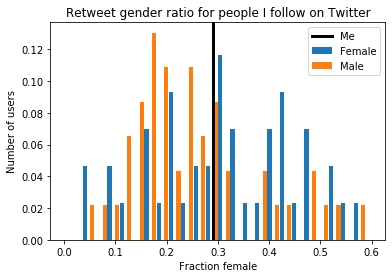

In [87]:
# plot a histogram of frac female following for samples and for me

fracfemale_retweet_f = np.zeros(nsample_female)
fracfemale_retweet_m = np.zeros(nsample_female)
nsample_retweet_f = 0
nsample_retweet_m = 0
minnretweets = 10
for i in range(nsample_female):
    if othernretweets[i] < minnretweets:
        fracfemale_retweet_f[i] = np.nan
        print('Bad sample %d'%i)
    else:
        fracfemale_retweet_f[i] = otherretweetinfo[i]['fracfemale'][-1]
        nsample_retweet_f += 1
    if othernretweets[i+nsample_female] < minnretweets:
        fracfemale_retweet_m[i] = np.nan
        print('Bad sample %d'%(i+nsample_female))
    else:
        fracfemale_retweet_m[i] = otherretweetinfo[i+nsample_female]['fracfemale'][-1]
        nsample_retweet_m += 1


idxgood_f = np.isnan(fracfemale_retweet_f) == False
idxgood_m = np.isnan(fracfemale_retweet_m) == False
        
myprctile_f = np.count_nonzero(fracfemale_retweet_f[idxgood_f]<=myretweetinfo['fracfemale'][-1])/nsample_retweet_f
myprctile_m = np.count_nonzero(fracfemale_retweet_m[idxgood_m]<=myretweetinfo['fracfemale'][-1])/nsample_retweet_m
print('My percentile among women I follow: %f'%(myprctile_f*100.))
print('My percentile among men I follow: %f'%(myprctile_m*100.))
print('My percentile among people I follow: %f'%((myprctile_f+myprctile_m)*50.))

counts_f,edges = np.histogram(fracfemale_retweet_f[idxgood_f],bins=25,range=(0,.6))
counts_m,edges = np.histogram(fracfemale_retweet_m[idxgood_m],bins=25,range=(0,.6))
ctrs = (edges[1:]+edges[:-1])/2.
normcounts_f = counts_f / np.sum(counts_f)
normcounts_m = counts_m / np.sum(counts_m)
plt.bar(ctrs+width/5.,normcounts_f,width=width*.35,color=colorf,label='Female')
plt.bar(ctrs-width/5.,normcounts_m,width=width*.35,color=colorm,label='Male')
ylim = plt.gca().get_ylim()
plt.plot([myretweetinfo['fracfemale'][-1]]*2,ylim,'k-',lw=3,label='Me')
plt.gca().set_ylim(ylim)
plt.legend()
plt.xlabel('Fraction female')
plt.ylabel('Number of users')
plt.title('Retweet gender ratio for people I follow on Twitter')

stats.mannwhitneyu(fracfemale_retweet_f[idxgood_f],fracfemale_retweet_m[idxgood_m],alternative='greater')


In [44]:
import pickle
filename = 'C:/Code/TwitterGenderRatio/test20200510.pickle'
fid = open(filename,'wb')
pickle.dump({'ids': ids, 'names': names,'idxsample': idxsample, 'names1': names1, 'ids1': ids1},fid)
fid.close()